# Active learning using kili-technology

In this tutorial, we will see results of active learning applied to object detection.

It is no secret that machine learning models, especially deep learning models, need lots of training data. In the real world, unsupervised data is plenty while supervised data is rare and costly to obtain. Thus, you may be interested in using active learning : it is the task of choosing well the data samples to annotate to get the best performance given a fixed number of annotations.

At kili-technology, we develop the best annotation platform, to quickly get a production ready dataset. One of the features of our python - graphQL API is the ability to order the data samples to annotate, by giving them priority. This allows the use of active learning algorithms.

Since training a whole detection network in a single jupyter notebook is not realistic (two in fact to make comparisons), we show you the results of an implementation of the paper by C. Brust, C. Käding and J. Denzler (2019) [Active learning for deep object detection](https://arxiv.org/pdf/1809.09875.pdf), in VISAPP. The simple idea behind the paper is to aggregate prediction uncertainties for each bounding box to compute an uncertainty per image.

![image info](../img/OD-method-aldod.png)

The sampling is done by batch, to avoid only querying outliers where the model fails a lot. Each batch has an aggregated score (the sum or average of the scores of each image), and this score is used to rank batches and select which batches (thus images) to use.

Other active learning for object detection exist, but we choose to try this simple method, because as our experiment show, **most of the cost of active learning is spent in implementation time**. Thus, it's often better to choose a simple fast-to-implement method rather than going for the high end methods. We list some other methods here :

- [Scalable Active Learning for Object Detection](https://www.groundai.com/project/scalable-active-learning-for-object-detection/) is the first large scale study of active learning for object detection, using hundreds of thousands of images. They test different scoring techniques and sampling strategies, with the assumption that the model outputs a 2D map of probabilities for each class. They aggregate object scores with a maximum or sum strategy.
- [Deep active learning for object detection](http://bmvc2018.org/contents/papers/0287.pdf) is a paper where they plug detector heads to different layers to form a type of query-by-committee algorithm using disagreement between layers.
- [Localization-aware active learning for object detection](https://arxiv.org/pdf/1801.05124.pdf) proposes to use region proposal algorithm to go further than simply measuring class uncertainties, by also measuring a "localization tightness score" which can indicate if the object was well detected. They also experiment adding different levels of noise to unlabeled data to measure stability to noise.
- [Active learning for deep detection neural networks](https://arxiv.org/pdf/1911.09168.pdf) propose a specific object detector model to compute a pixel level uncertainty from different layers of the network like in "Deep active learning for object detection".

In [1]:
# Clone repository where the code and experiments are run
!git clone https://github.com/mDuval1/SSD

Cloning into 'SSD'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 1040 (delta 93), reused 199 (delta 73), pack-reused 807
Receiving objects: 100% (1040/1040), 875.51 KiB | 2.05 MiB/s, done.
Resolving deltas: 100% (543/543), done.


In [2]:
import glob
from functools import partial
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

### Raw performance experiments

In [3]:
data_models = glob.glob('SSD/outputs/*')

In [41]:
list_df = []
no_training_failure = {'20200621170027'}
for data_model in data_models:
    model_results = glob.glob(f'{data_model}/results/*.txt')
    for model_result in model_results:
        if model_result.split('/')[-1].split('-')[1].split('.')[0] in no_training_failure:
            df_model = pd.read_csv(model_result)
            df_model['model'] = model_result.split('/')[-1]
            df_model['data'] = data_model.split('/')[-1]
            list_df.append(df_model)

In [42]:
df = pd.concat(list_df).reset_index()

In [43]:
df

,index,strategy,args,step,mAP,model,data
0,0,random_sampling,{},1,0.206222,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
1,1,random_sampling,{},2,0.268997,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
2,2,random_sampling,{},3,0.326994,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
3,3,random_sampling,{},4,0.344545,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
4,4,random_sampling,{},5,0.364667,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
5,5,random_sampling,{},6,0.380813,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
6,6,random_sampling,{},7,0.402676,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
7,7,random_sampling,{},8,0.421956,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
8,8,random_sampling,{},9,0.423423,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
9,9,random_sampling,{},10,0.447424,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712


Dataset : Pascal VOC (train : train 2012 ; test : test 2007)
Model : mobilenetv2

Text(0.5, 1.0, 'mobilenet_v2_ssd320_voc0712')

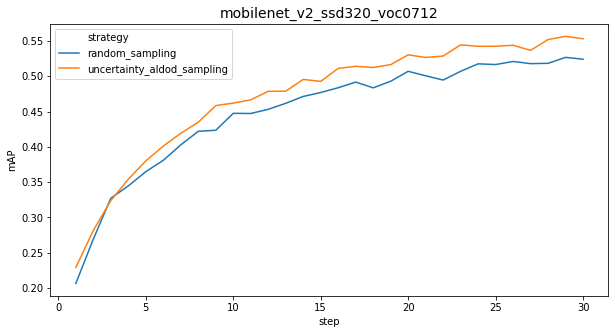

In [44]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='step', y='mAP', hue='strategy', data=df)
plt.title(df.loc[0, 'data'], fontsize=14)

In [45]:
df['step'] = df['step'].astype(np.int32)

Text(0.5, 1.0, 'mobilenet_v2_ssd320_voc0712')

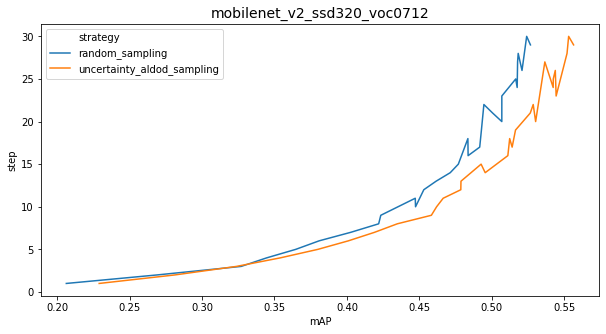

In [46]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='mAP', y='step', hue='strategy', data=df)
plt.title(df.loc[0, 'data'], fontsize=14)

In [47]:
last_time = max(list(map(lambda x: x.split('-')[-1], list(set(df.loc[df.strategy == 'random_sampling'].model)))))

In [48]:
def get_single_experiment(df, model, strategy):
    return df.loc[(df.model == f"{strategy}-{model}"), ['step', 'mAP']].reset_index(drop=True)

In [49]:
df_aldod = get_single_experiment(df, last_time, "uncertainty_aldod_sampling")
df_random = get_single_experiment(df, last_time, "random_sampling")
diff = df_aldod['mAP'] - df_random['mAP']

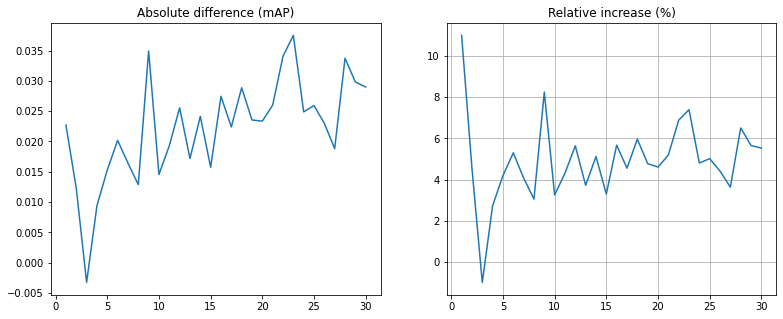

In [50]:
fig, axs = plt.subplots(figsize=(13, 5), ncols=2)
axs[0].plot(df_aldod['step'], diff)
axs[0].set_title('Absolute difference (mAP)')
axs[1].plot(df_aldod['step'], diff/df_random['mAP']*100)
axs[1].set_title('Relative increase (%)')
axs[1].grid()

In [51]:
perfs = np.linspace(df_random['mAP'].min(), df_random['mAP'].max(), 100)
def get_min_step(x, df):
    return (df['mAP'] < x).argmin()
min_random = np.array(list(map(partial(get_min_step, df=df_random), perfs)))
min_aldod = np.array(list(map(partial(get_min_step, df=df_aldod), perfs)))
diff_steps = min_random - min_aldod

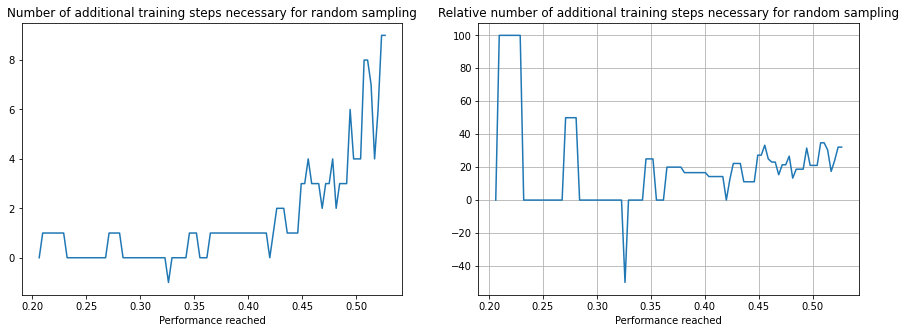

In [52]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=2)
axs[0].plot(perfs, diff_steps)
axs[0].set_xlabel('Performance reached')
axs[0].set_title('Number of additional training steps necessary for random sampling')
axs[1].plot(perfs, diff_steps/np.maximum(1, min_random)*100)
axs[1].set_xlabel('Performance reached')
axs[1].set_title('Relative number of additional training steps necessary for random sampling')
axs[1].grid()

Using active learning for object detection augments by 5% the performance for the same annotation budget, or reduces by 20 to 30% the number of images to annotate for the same performance.

### More detailed experiments, with time metrics

Let's look at these other experiments :

In [14]:
models = ['mobilenet_v2_ssd320_voc0712']
algorithms = ['random_sampling', 'uncertainty_aldod_sampling']
experiments = ['experiment-20200629144455', 'experiment-20200630090523', 'experiment-20200701095400']
root_results = 'SSD/outputs'

In [15]:
list_results = []
list_queries = []
model = 'mobilenet_v2_ssd320_voc0712'
for algorithm in algorithms:
    for experiment in experiments:
        df_csv = pd.read_csv(f'{root_results}/{model}/results/{algorithm}/{experiment}/csv.txt')
        df_queries = pd.read_csv(f'{root_results}/{model}/results/{algorithm}/{experiment}/queries.txt')
        for df in [df_csv, df_queries]:
            df['algorithm'] = algorithm
            df['experiment'] = experiment
        list_results.append(df_csv)
        list_queries.append(df_queries)
df = pd.concat(list_results)
df_queries = pd.concat(list_queries)

The performance is still good

Text(0.5, 1.0, 'mobilenet_v2_ssd320_voc0712')

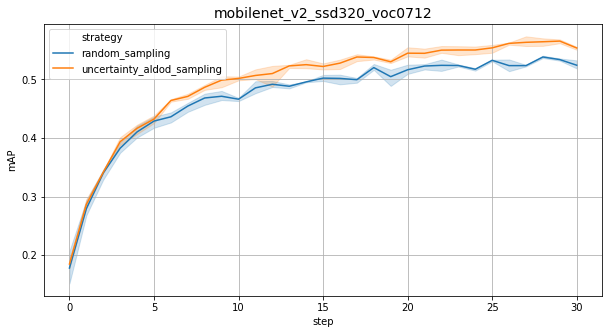

In [17]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='step', y='mAP', hue='strategy', data=df)
plt.grid()
plt.title(model, fontsize=14)

Even when taking into account the supplementary time taken by the active algorithm :

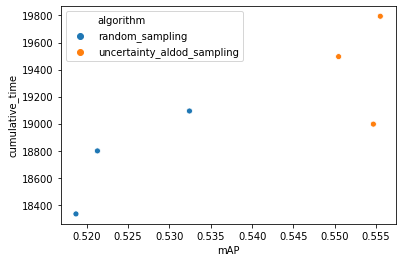

In [19]:
df['cumulative_time'] = df.groupby(['algorithm', 'experiment'])['total_time'].cumsum()
sns.scatterplot(x='mAP', y='cumulative_time', hue='algorithm', data=df.loc[df.step==30])

Text(0.5, 1.0, 'Performance achieved as a function of time')

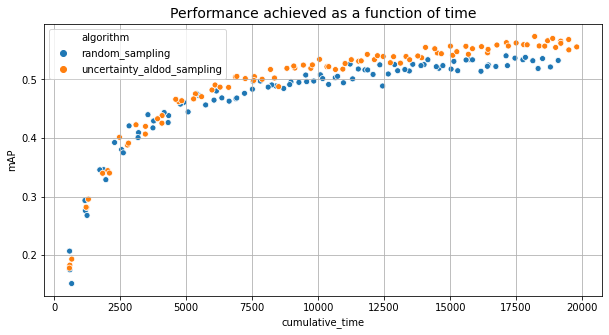

In [20]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='cumulative_time', y='mAP', hue='algorithm', data=df)
plt.grid()
plt.title('Performance achieved as a function of time', fontsize=14)

In [21]:
mean_times = df.loc[df.step==30].groupby('algorithm')['cumulative_time'].mean()

In [22]:
time_with_AL = mean_times['uncertainty_aldod_sampling']
time_without_AL = mean_times['random_sampling']
relative_difference = (time_with_AL - time_without_AL) / time_without_AL
print(f'Training time increase when using active learning : {relative_difference:.2%}')

Training time increase when using active learning : 3.67%


But in the reality, your model needs to wait for the annotaters to label your samples. If we estimate 5s per bounding box, 2 people working full time (for Pascal VOC with on average 2 bounding boxes per image), the relative difference is decreased, even though there are more bounding boxes requested by the active learning model.

In [26]:
mean_nb_bbox = df.loc[df.step == 30, ['algorithm', 'bboxes']].groupby(['algorithm']).mean()
bbox_with_AL = mean_nb_bbox.loc['uncertainty_aldod_sampling', 'bboxes']
bbox_without_AL = mean_nb_bbox.loc['random_sampling', 'bboxes']
print(f'Number of bounding boxes used with AL : {int(bbox_with_AL)} - without = {int(bbox_without_AL)}')

Number of bounding boxes used with AL : 27114 - without = 26771


In [27]:
time_with_AL_annotations = time_with_AL + bbox_with_AL * 5
time_without_AL_annotations = time_without_AL + bbox_without_AL * 5
real_relative_difference = (time_with_AL_annotations - time_without_AL_annotations) / time_without_AL_annotations
print(f'Real model training time increase when using active learning : {real_relative_difference:.2%}')

Real model training time increase when using active learning : 1.58%


### Are we winning money wise ? 

#### Not here...

The goal is to reach 0.50 mAP with MobileNetv2 on Pascal VOC.

- Implementation cost compared to a traditional implementation
    - Setting up the training pipeline : 4h
        - Maintain two datasets, one labeled, the other unlabeled
        - Query mechanism
        - Training on labeled
    - Setting up the AL algorithm : algorithm / task dependant : 
        - Usually, the better the algorithm, the more time consumed for this part.
        - Classification, simple margin sampling : 1h
        - Object detection, paper : 4h
    - Total : 1 day of a data scientist : +500 €
- Annotation cost
    - 5 less steps (10 instead of 15) : $5 \times 150 = 750$ less assets, 2 bounding box each, 0.05 € per bbox :
    - Total : $750 \times 2 \times 0.05 =  -75$ €
- Compute cost
    - Around 2500 less seconds.
    - Google, tesla V100 1h : 2 €
    - Total : -2 €
    - But with development costs : ~ +20 €
- Total : **+445 €**

Conclusion : for a project with this size, it not interesting to use active learning. 

#### ... but you save money for big enough projects

Since data science costs are fixed, for a project with either:

- x10 more need in terms of time spent per asset (high number of objects, higher number of classes...)
- x10 more need in project size (number of images to annotate to reach the desired performance)

**then AL is interesting**.

For example, consider a project for retail or autonomous vehicles with :

- 25k images
- 0.07 €/bbox
- 5 bbox / images

Then realistically if using active learning you only have to annotate 20k images to get to the same performance, you save $5000 \times 0.07 \times 5 = 1750$€ in terms of annotation only with active learning, so overall **1250€** saved.

At kili we are 100% devoted to helping you ship your machine learning projects faster, and we will continue to investigate how we can reduce frictions to help you use active learning.